In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
import time
import sklearn
from sklearn.model_selection import train_test_split
from random import shuffle
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import KNNWithMeans
import seaborn as sns    

### Read train and test datast

In [0]:
train_ratings = pd.read_csv("train_data.csv")
test_ratings = pd.read_csv("test_data.csv")

In [5]:
print('train_minimum_rating',min(train_ratings['rating']))
print('train_maximum_rating',max(train_ratings['rating']))
print('test_minimum_rating',min(train_ratings['rating']))
print('test_maximum_rating',max(train_ratings['rating']))

('train_minimum_rating', 0.5)
('train_maximum_rating', 5.0)
('test_minimum_rating', 0.5)
('test_maximum_rating', 5.0)


In [0]:
reader = Reader(rating_scale=(0.5, 5))
ratings = Dataset.load_from_df(train_ratings, reader)

In [0]:
raw_ratings = ratings.raw_ratings
random.seed(42)
shuffle(raw_ratings)

In [0]:
ratings.raw_ratings = raw_ratings 

In [0]:
copy_ratings=ratings

### define coverage function

In [0]:
def coverage(threshold1, threshold2,prediction):
    start_time=time.time()
    predictions = pd.DataFrame(prediction)
    pred = predictions.groupby('uid')
    df1= pred.apply(lambda x: x.sort_values(by=["est"],ascending=False))
    df2=df1.reset_index(drop=True)
    df3 = df2.groupby('uid').head(10)

    s1=df3[df3['r_ui'] > threshold1].groupby('uid')['r_ui'].count().reset_index()
    s2 = df3.pivot_table(index=['uid'],aggfunc='size').reset_index()
    s2.columns = ['uid','counts']

    df=pd.merge(s1, s2, on='uid')

    # #number of high true rating(larger than 4) devided by top N predictions
    df['rate']=df['r_ui']/df['counts']

    user_coverage=float(sum(df['rate']> threshold2))/df3['uid'].nunique()

    item=df3.groupby('iid').apply(lambda x: x.sort_values(by=["est"],ascending=False)).reset_index(drop=True)

    s=item[item['r_ui'] > threshold1].groupby('iid')['r_ui'].count().reset_index()
    ss = item.pivot_table(index=['iid'],aggfunc='size').reset_index()
    ss.columns = ['iid','counts']
    dff=pd.merge(s, ss, on='iid')
    dff['rate']=dff['r_ui']/dff['counts']
    item_coverage=float(sum(dff['rate']> threshold2))/df3['iid'].nunique()

    catalog_coverage = float(df3['iid'].nunique())/predictions['iid'].nunique()
    end_time=time.time()
    duration=end_time-start_time
    return user_coverage, item_coverage, catalog_coverage,duration


#### First we run a 5-fold cv on the train set to see some preliminary results.

In [0]:
method = KNNWithMeans()
cross_val = cross_validate(method, ratings, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6896  0.6839  0.6860  0.6854  0.6848  0.6859  0.0019  
RMSE (testset)    0.8932  0.8853  0.8891  0.8883  0.8863  0.8884  0.0027  
Fit time          52.61   55.89   48.68   47.90   43.54   49.72   4.22    
Test time         229.95  195.13  206.80  185.43  179.84  199.43  17.80   


### cross-validation on similarity measure

In [0]:
def try_similarity(options): 
    method = KNNWithMeans(sim_option=options)
    cross_val = cross_validate(method, ratings, measures=['RMSE', 'MAE'], return_train_measures=True,cv=5, verbose=False)
    
    train_mae=np.mean(cross_val['train_mae'])
    train_rmse=np.mean(cross_val['train_rmse'])
    
    val_mae=np.mean(cross_val['test_mae'])
    val_rmse=np.mean(cross_val['test_rmse'])
    

    return train_rmse,train_mae,val_rmse,val_mae

In [29]:
train_rmse_list2=[]
train_mae_list2=[]
val_rmse_list2=[]
val_mae_list2=[]



similarity_measure = {
    'cosine': {
         'name': 'cosine',
         'user_based': False 
         },
    'pearson_baseline': {
         'name': 'pearson_baseline',
         'user_based': False 
         },
    'pearson': {
         'name': 'pearson',
         'user_based': False
         }
         }

_min=float('inf')

for k, v in similarity_measure.items():
        
  
    print('similarity measure is', k)
        

    train_rmse,train_mae,val_rmse,val_mae=try_similarity(v)
    train_rmse_list2.append(train_rmse)
    train_mae_list2.append(train_mae)
   
    val_rmse_list2.append(val_rmse)
    val_mae_list2.append(val_mae)
    if val_rmse<_min:
        _min=val_rmse
        _similarity_measure=v
        
        

        
        
print("similarity  measure that produce the smallest rmse are",_similarity_measure)

('similarity measure is', 'pearson')
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
('similarity measure is', 'pearson_baseline')
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
('similarity measure is', 'cosine')
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Compu

In [31]:
train_rmse_list2

[0.5742714680792438, 0.5742435830705317, 0.574299879424325]

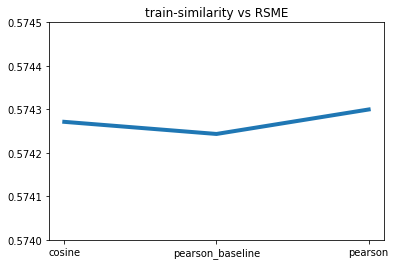

In [61]:
measure_list=['cosine', 'pearson_baseline', 'pearson']
lines = plt.plot(measure_list,train_rmse_list2)
plt.setp(lines[0], linewidth=4)
#plt.setp(lines[1], linewidth=2)
#plt.setp(lines[2], markersize=10)
plt.ylim(0.574, 0.5745)
# plt.legend(('train_mae', 'test_mae'),
#            loc='upper right')
plt.title('train-similarity vs RSME')
plt.savefig('train-similarity vs RSME.jpg')
plt.show()

In [59]:
val_rmse_list2

[0.8882402636248046, 0.8880093120223037, 0.8880535904651804]

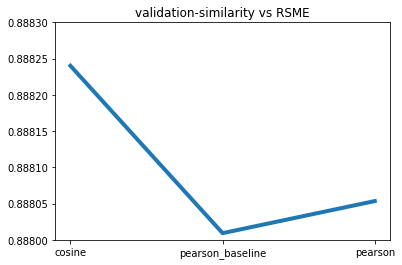

In [62]:
measure_list=['cosine', 'pearson_baseline', 'pearson']
lines = plt.plot(measure_list,val_rmse_list2)
plt.setp(lines[0], linewidth=4)
#plt.setp(lines[1], linewidth=2)
#plt.setp(lines[2], markersize=10)
plt.ylim(0.888, 0.8883)
# plt.legend(('train_mae', 'test_mae'),
#            loc='upper right')
plt.title('validation-similarity vs RSME')
plt.savefig('validation-similarity vs RSME.jpg')
plt.show()

In [63]:
val_mae_list2

[0.6860475819568472, 0.6857530678860657, 0.6857958678485091]

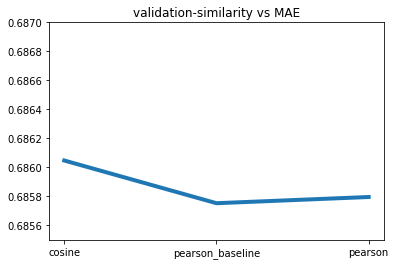

In [65]:
measure_list=['cosine', 'pearson_baseline', 'pearson']
lines = plt.plot(measure_list,val_mae_list2)
plt.setp(lines[0], linewidth=4)
#plt.setp(lines[1], linewidth=2)
#plt.setp(lines[2], markersize=10)
plt.ylim(0.6855, 0.687)
# plt.legend(('train_mae', 'test_mae'),
#            loc='upper right')
plt.title('validation-similarity vs MAE')
plt.savefig('validation-similarity vs MAE.jpg')
plt.show()

### cross-validation on neighborhood size

In [0]:
def try_neighbor(kNeighbor,_similarity_measure): 
    method = KNNWithMeans(min_k=kNeighbor,sim_option=_similarity_measure)
    cross_val = cross_validate(method, ratings, measures=['RMSE', 'MAE'], return_train_measures=True,cv=5, verbose=False)
    
    train_mae=np.mean(cross_val['train_mae'])
    train_rmse=np.mean(cross_val['train_rmse'])
    
    val_mae=np.mean(cross_val['test_mae'])
    val_rmse=np.mean(cross_val['test_rmse'])
    

    return train_rmse,train_mae,val_rmse,val_mae

In [27]:
train_rmse_list=[]
train_mae_list=[]
val_rmse_list=[]
val_mae_list=[]


neighbor_num = np.arange(5, 70 , 10)

_min=float('inf')
for num in neighbor_num:
    
        
    print('number of neighbor', num)
       
        

    train_rmse,train_mae,val_rmse,val_mae=try_neighbor(num,{'name': 'pearson_baseline', 'user_based': False})
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
   
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)
    if val_rmse<_min:
        _min=val_rmse
        _num=num
            
        
        
        
    
        
        
print("number of neighbor that produce the smallest rmse are", _num)

('number of neighbor', 5)
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
('number of neighbor', 15)
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
('number of neighbor', 25)
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done 

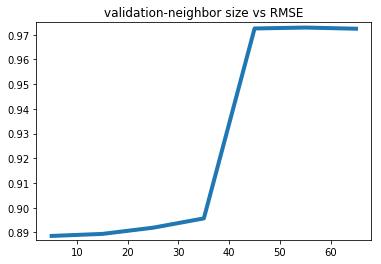

In [33]:
lines = plt.plot(neighbor_num,val_rmse_list)
plt.setp(lines[0], linewidth=4)

plt.ylim(0.887, 0.975)

plt.title('validation-neighbor size vs RMSE')
plt.savefig('validation-neighborsize_vs_RMSE.jpg')
plt.show()

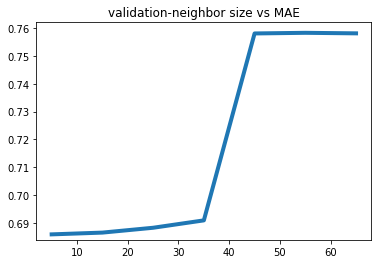

In [36]:
lines = plt.plot(neighbor_num,val_mae_list)
plt.setp(lines[0], linewidth=4)

plt.ylim(0.684, 0.762)

plt.title('validation-neighbor size vs MAE')
plt.savefig('validation-neighborsize_vs_MAE.jpg')
plt.show()

### evaluate on test set with the parameters we searched

In [37]:
train_ratings = pd.read_csv("train_data.csv")
test_ratings = pd.read_csv("test_data.csv")
reader = Reader(rating_scale=(0.5, 5))
ratings = Dataset.load_from_df(train_ratings, reader)
raw_ratings = ratings.raw_ratings
random.seed(42)
shuffle(raw_ratings)
ratings.raw_ratings = raw_ratings 

train_set = ratings.build_full_trainset()
reader = Reader(rating_scale=(0.5, 5))
test_rates = Dataset.load_from_df(test_ratings, reader)
test=test_rates.raw_ratings
test_set = ratings.construct_testset(test)

In [38]:
method = KNNWithMeans(min_k=5,sim_option={
         'name': 'pearson_baseline',
         'user_based': False 
         })
method.fit(train_set)
test_result = method.test(test_set)
test_rmse = accuracy.rmse(test_result)
test_mae = accuracy.mae(test_result)
r_user_coverage,r_item_coverage,r_catelog_coverage,_=coverage(4.0, 0.5,test_result)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8868
MAE:  0.6843


In [39]:
print(r_user_coverage,r_item_coverage,r_catelog_coverage)

(0.17297840281265695, 0.090234375, 0.8539026017344896)


### Evaluate the relationship between running time and scale of dataset

In [0]:
train_ratings = pd.read_csv("train_data.csv")
test_ratings = pd.read_csv("test_data.csv")

In [0]:
reader = Reader(rating_scale=(0.5, 5))
ratings = Dataset.load_from_df(train_ratings, reader)
raw_ratings = ratings.raw_ratings
random.seed(42)
shuffle(raw_ratings)
ratings.raw_ratings = raw_ratings 
copy_ratings=ratings

In [0]:
def default_knn(train_set,test_set):
    start_time = time.time()
    method = KNNWithMeans()
    method.fit(train_set)
    
    print('evaluate on train set')
    train_result = method.test(train_set.build_testset())
    train_rmse = accuracy.rmse(train_result)
    train_mae = accuracy.mae(train_result)
    r_user_coverage,r_item_coverage,r_catelog_coverage,_=coverage(4.0, 0.5,train_result)
    
    print('evaluate on test set')
    test_result = method.test(test_set)
    #print(len(test_result))
    test_rmse = accuracy.rmse(test_result)
    test_mae = accuracy.mae(test_result)
    
    e_user_coverage,e_item_coverage,e_catelog_coverage,_=coverage(4.0, 0.5,test_result)
    return train_rmse,test_rmse,train_mae,test_mae,\
r_user_coverage,r_item_coverage,r_catelog_coverage,\
e_user_coverage,e_item_coverage,e_catelog_coverage

In [0]:
def change_size(size,copy_ratings):
    use_rating=copy_ratings
    
    use_raw_ratings = use_rating.raw_ratings
#    print(len(use_raw_ratings))
#     random.seed(42)
#     shuffle(use_raw_ratings)
    
    use_part, holdout_group= train_test_split(use_raw_ratings, test_size=size, random_state=50)
    train, test= train_test_split(use_part, test_size=0.2, random_state=50)
    #train, test= train_test_split(use_part, test_size=0.15, random_state=42)
    #print(train)
    use_rating.raw_ratings = train
    train_set = use_rating.build_full_trainset()
    test_set = use_rating.construct_testset(test)
    
    start_time = time.time()
    print('use'+" "+str(round((1-size)*100,2))+"% of data")
    train_rmse,test_rmse,train_mae,test_mae,\
    r_user_coverage,r_item_coverage,r_catelog_coverage,\
    e_user_coverage,e_item_coverage,e_catelog_coverage =default_knn(train_set,test_set)
    
    end_time = time.time()
    
    duration=end_time-start_time
    return train_rmse,test_rmse,train_mae,test_mae,duration,\
r_user_coverage,r_item_coverage,r_catelog_coverage,\
e_user_coverage,e_item_coverage,e_catelog_coverage

In [15]:
size_train_rmse_list=[]
size_train_mae_list=[]
size_test_rmse_list=[]
size_test_mae_list=[]
size_e_u_cov=[]
size_e_i_cov=[]
size_e_c_cov=[]
size_r_u_cov=[]
size_r_i_cov=[]
size_r_c_cov=[]
size_list = np.arange(0.1, 1.0, 0.1)
duration_list=[]
for size in size_list:
    reader = Reader(rating_scale=(0.5, 5))
    ratings = Dataset.load_from_df(train_ratings, reader)
    raw_ratings = ratings.raw_ratings
    random.seed(42)
    shuffle(raw_ratings)
    ratings.raw_ratings = raw_ratings 
    copy_ratings=ratings
    train_rmse,train_mae,test_rmse,test_mae,duration,\
    r_user_coverage,r_item_coverage,r_catelog_coverage,\
    e_user_coverage,e_item_coverage,e_catelog_coverage=change_size(size,copy_ratings)
    size_train_rmse_list.append(train_rmse)
    size_train_mae_list.append(train_mae)
   
    size_test_rmse_list.append(test_rmse)
    size_test_mae_list.append(test_mae)
    
    size_e_u_cov.append(e_user_coverage)
    size_e_i_cov.append(e_item_coverage)
    size_e_c_cov.append(e_catelog_coverage)
    
    size_r_u_cov.append(r_user_coverage)
    size_r_i_cov.append(r_item_coverage)
    size_r_c_cov.append(r_catelog_coverage)
    
    duration_list.append(duration)
    print('duration is',duration)

use 90.0% of data
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluate on train set
RMSE: 0.5677
MAE:  0.4209
evaluate on test set
RMSE: 0.8889
MAE:  0.6855
('duration is', 442.4302878379822)
use 80.0% of data
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluate on train set
RMSE: 0.5607
MAE:  0.4156
evaluate on test set
RMSE: 0.8910
MAE:  0.6875
('duration is', 376.3689777851105)
use 70.0% of data
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluate on train set
RMSE: 0.5543
MAE:  0.4108
evaluate on test set
RMSE: 0.8943
MAE:  0.6888
('duration is', 300.5175588130951)
use 60.0% of data
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluate on train set
RMSE: 0.5486
MAE:  0.4065
evaluate on test set
RMSE: 0.9002
MAE:  0.6926
('duration is', 225.91154599189758)
use 50.0% of data
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluate on train set
RM

In [0]:
sample_size_list=[1-i for i in size_list]
model_size = pd.DataFrame()
model_size['Sample_size']=sample_size_list
model_size['Running_time']=duration_list
model_size['RMSE_test']=size_test_rmse_list
model_size['MAE_test']=size_test_mae_list
model_size['Catalog_Coverage_test']=size_e_c_cov
model_size['User_Coverage_test']=size_e_u_cov
model_size['Item_Coverage_test']=size_e_i_cov
# model_size = pd.DataFrame(
#     {'Sample_size': sample_size_list,
#      'Running_time': duration_list,
#      #'RMSE_train': size_train_rmse_list,
#      'RMSE_test': size_test_rmse_list,
#      #'MAE_train': size_train_mae_list,
#      'MAE_test': size_test_mae_list,
#      #'Catalog_Coverage_train': r_catelog_coverage,
#      'Catalog_Coverage_test': e_catelog_coverage,
#      #'User_Coverage_train': r_user_coverage,
#      'User_Coverage_test': e_user_coverage,
#      #'Item_Coverage_train': r_item_coverage,
#      'Item_Coverage_test': e_item_coverage
#     })
# print(model_size)

#### Show all results in a table

In [17]:
model_size

,Sample_size,Running_time,RMSE_test,MAE_test,Catalog_Coverage_test,User_Coverage_test,Item_Coverage_test
0,0.9,442.430288,0.420921,0.685512,0.863362,0.170248,0.088053
1,0.8,376.368978,0.415579,0.687515,0.868032,0.164899,0.090135
2,0.7,300.517559,0.410756,0.688753,0.879892,0.163310,0.084356
3,0.6,225.911546,0.406459,0.692610,0.873559,0.162923,0.088475
4,0.5,163.902508,0.403340,0.696561,0.892588,0.168214,0.087274
5,0.4,110.614296,0.403032,0.700575,0.890300,0.170131,0.080032
6,0.3,73.140638,0.402568,0.713519,0.908629,0.180743,0.096568
7,0.2,43.750142,0.405119,0.737185,0.931102,0.183816,0.096406
8,0.1,23.693559,0.405444,0.823369,0.972909,0.191933,0.091353


### Plot graph

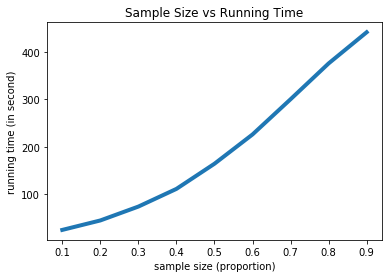

In [42]:

lines = plt.plot(sample_size_list,duration_list)
plt.setp(lines[0], linewidth=4)
#plt.setp(lines[1], linewidth=2)
#plt.setp(lines[2], markersize=10)


plt.xlabel('sample size (proportion)')
plt.ylabel('running time (in second)')
plt.title('Sample Size vs Running Time')
plt.savefig('S vs time')
plt.show()

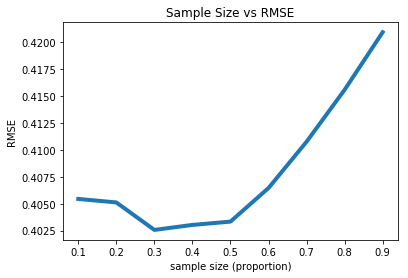

In [45]:
lines = plt.plot(sample_size_list,size_test_rmse_list)
plt.setp(lines[0], linewidth=4)
#plt.setp(lines[1], linewidth=2)
#plt.setp(lines[2], markersize=10)


plt.xlabel('sample size (proportion)')
plt.ylabel('RMSE')
plt.title('Sample Size vs RMSE')
plt.savefig('S vs RMSE')
plt.show()

In [0]:
model_size.to_csv('model_size.csv',index=False)